C:\Users\mukul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}


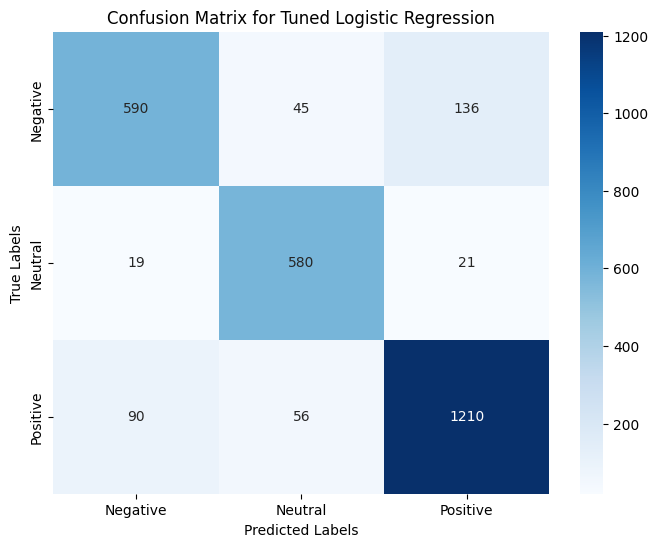


Metrics for Tuned Logistic Regression:

Negative Sentiment:
  Precision: 0.84
  Recall: 0.77
  F1-Score: 0.80
  Support: 771

Neutral Sentiment:
  Precision: 0.85
  Recall: 0.94
  F1-Score: 0.89
  Support: 620

Positive Sentiment:
  Precision: 0.89
  Recall: 0.89
  F1-Score: 0.89
  Support: 1356

Overall Metrics:
                       Model  Accuracy (%)  Precision    Recall  F1-Score  \
0  Tuned Logistic Regression     86.639971   0.860301  0.864351  0.861023   

   Support  
0     2747  


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'tweets1_processed.csv'
tweets_df = pd.read_csv(file_path)

# Encode the target variable
label_encoder = LabelEncoder()
tweets_df['sentiment_encoded'] = label_encoder.fit_transform(tweets_df['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tweets_df['processed_text'], 
    tweets_df['sentiment_encoded'], 
    test_size=0.2, 
    random_state=42
)

# Convert text data into numerical format using Bag of Words vectorization
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm
    'max_iter': [100, 500, 1000]  # Maximum number of iterations
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_bow, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Initialize Logistic Regression with the best parameters
best_log_reg = LogisticRegression(**best_params)

# Train the model with best parameters
best_log_reg.fit(X_train_bow, y_train)

# Predict on the test set
y_pred_best = best_log_reg.predict(X_test_bow)

# Evaluate the model
metrics_best = precision_recall_fscore_support(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Plotting the confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_best, "Tuned Logistic Regression")

# Class-specific metrics
def class_specific_metrics(y_test, y_pred):
    metrics = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2])
    return {
        "Negative": {
            "Precision": metrics[0][0],
            "Recall": metrics[1][0],
            "F1-Score": metrics[2][0],
            "Support": metrics[3][0]
        },
        "Neutral": {
            "Precision": metrics[0][1],
            "Recall": metrics[1][1],
            "F1-Score": metrics[2][1],
            "Support": metrics[3][1]
        },
        "Positive": {
            "Precision": metrics[0][2],
            "Recall": metrics[1][2],
            "F1-Score": metrics[2][2],
            "Support": metrics[3][2]
        }
    }

best_metrics = class_specific_metrics(y_test, y_pred_best)

# Print the results in a structured format
def print_metrics(model_name, metrics):
    print(f"\nMetrics for {model_name}:")
    for sentiment, scores in metrics.items():
        print(f"\n{sentiment} Sentiment:")
        print(f"  Precision: {scores['Precision']:.2f}")
        print(f"  Recall: {scores['Recall']:.2f}")
        print(f"  F1-Score: {scores['F1-Score']:.2f}")
        print(f"  Support: {scores['Support']}")

print_metrics("Tuned Logistic Regression", best_metrics)

# Overall results
overall_results = {
    "Model": ["Tuned Logistic Regression"],
    "Accuracy (%)": [
        accuracy_score(y_test, y_pred_best) * 100
    ],
    "Precision": [
        metrics_best[0].mean()
    ],
    "Recall": [
        metrics_best[1].mean()
    ],
    "F1-Score": [
        metrics_best[2].mean()
    ],
    "Support": [
        metrics_best[3].sum()
    ]
}

overall_results_df = pd.DataFrame(overall_results)

print("\nOverall Metrics:")
print(overall_results_df)
